# Conditional distributions using Gaussian copula

In this notebook we illustrate the theory presented in the paper [A. Novosyolov, Conditional distrubutions using copula function](https://www.researchgate.net/publication/321748056_Conditional_distributions_using_copula_function)

In [1]:
import pandas as pd
import seaborn as sns
import gaussian_copula_stuff as gcs
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Artificial example

Create a correlation matrix $4\times4$

In [2]:
# create artificial correlation matrix
sa = np.array([[1, 0.5, -0.1, 0.3],
               [0.5, 1, -0.5, 0.2],
               [-0.1, -0.5, 1, 0.3],
               [0.3, 0.2, 0.3, 1]])
# ensure it is symmetric
sa = 0.5 * (sa + sa.T)

# check if it is positive definite
ev, _ = np.linalg.eigh(sa)
rig = (ev > 0).all()
if rig:
    print('Matrix is positive definite')
else:
    print('Matrix is not positive definite!!! Eigenvalues:')
    print(ev)

# convert correlation matrix to DataFrame
cls = np.array(['first', 'second', 'third', 'fourth'])
s = pd.DataFrame(sa, columns=cls, index=cls)
s.index.name = 'factor'

# print the matrix out
print(s)

Matrix is positive definite
        first  second  third  fourth
factor                              
first     1.0     0.5   -0.1     0.3
second    0.5     1.0   -0.5     0.2
third    -0.1    -0.5    1.0     0.3
fourth    0.3     0.2    0.3     1.0


Create a Gaussian copula with this correlation matrix as a parameter.

In [3]:
cop = gcs.GaussianCopula(s)

### Marginal PDFs

Draw a contour plot of a marginal bivariate PDF.

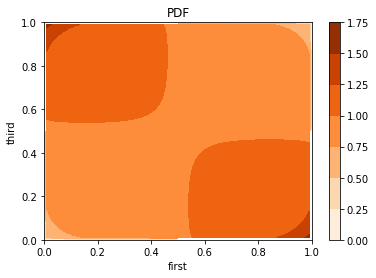

In [4]:
def bi_marg_target(cop, targets):
    """ """
    nn = 101
    n2 = nn ** 2
    x = np.linspace(0, 1, nn)
    y = x.copy()
    x, y = np.meshgrid(x, y)
    x_2 = np.concatenate((x.reshape(n2, 1), y.reshape(n2, 1)), axis=1)
    x_2df = pd.DataFrame(x_2, columns=targets)

    z = cop.marg_pdf(x_2df).values.reshape(nn, nn)
    cp = contourf(x, y, z, cmap='Oranges')
    colorbar(cp)
    xlabel(targets[0])
    ylabel(targets[1])
    title('PDF')
bi_marg_target(cop, ['first', 'third'])

The same for another components pair.

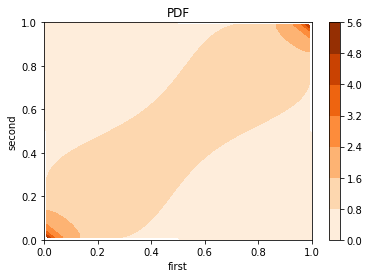

In [5]:
bi_marg_target(cop, ['first', 'second'])

### Conditional PDFs

Now let's plot a few conditional distribution presentations.

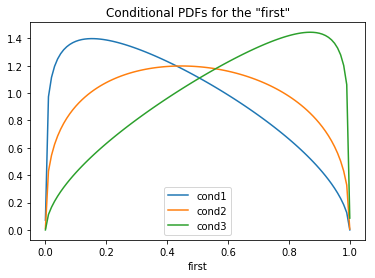

In [6]:
target = ['first']
cond = ['second', 'third', 'fourth']
u = pd.DataFrame(np.linspace(0, 1, 101), columns=target)
u_cond1 = pd.DataFrame([[0.2, 0.5, 0.8]], columns=cond)
u_cond2 = pd.DataFrame([[0.3, 0.6, 0.9]], columns=cond)
u_cond3 = pd.DataFrame([[0.4, 0.8, 0.99]], columns=cond)
cop.cond_pdf(u, u_cond1).plot(label='cond1');
cop.cond_pdf(u, u_cond2).plot(label='cond2');
cop.cond_pdf(u, u_cond3).plot(label='cond3');
legend();
title('Conditional PDFs for the "{0}"'.format(target[0]));

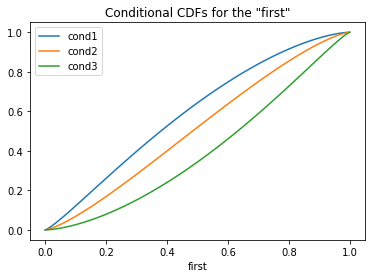

In [7]:
cop.cond_cdf(u, u_cond1).plot(label='cond1');
cop.cond_cdf(u, u_cond2).plot(label='cond2');
cop.cond_cdf(u, u_cond3).plot(label='cond3');
legend();
title('Conditional CDFs for the "{0}"'.format(target[0]));

## Real assets example

Next we consider joint distribution of returns for a number of stocks, fit it to a multivariate distribution using Gaussian copula, and present some conditional densities and cumulative distribution functions.

In [8]:
# read quotes from 2012 till now, and select just four stocks for presentation
to_keep = ['apple', 'ebay', 'boeing', 'visa']
df = pd.read_csv('stocks.csv').set_index('date')['2012':][to_keep]

In [9]:
# create multivariate distribution
md = gcs.MultiVarDistribution()

# fit it to data, using Gaussian copula and Student t marginals
md.fit(df, marg_typ='t')

In [10]:
# conditional PDFs for a stock, given other stocks returns
def all_pdfs(cl):
    """ """
    targ = [cl]
    cond = [s for s in to_keep if not s in targ]
    
    x_min = df[cl].min()
    x_max = df[cl].max()
    x = pd.DataFrame(np.linspace(x_min, x_max, 101), columns=targ)
    x_cond1 = pd.DataFrame([[0.04, 0.04, 0.04]], columns=cond)
    x_cond2 = pd.DataFrame([[-0.04, -0.04, -0.04]], columns=cond)
    x_cond3 = pd.DataFrame([[0.0, 0.0, 0.0]], columns=cond)
    pd.Series(np.array(md.marg_pdf(x)), index=x[cl]).plot(label='marginal');
    pd.Series(np.array(md.cond_pdf(x, x_cond1)), index=x[cl]).plot(label='cond1');
    pd.Series(np.array(md.cond_pdf(x, x_cond2)), index=x[cl]).plot(label='cond2');
    pd.Series(np.array(md.cond_pdf(x, x_cond3)), index=x[cl]).plot(label='cond3');
    legend();
    title('Marginal and conditional densities for "{0}"'.format(cl));

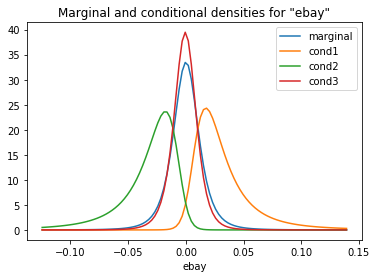

In [11]:
all_pdfs(to_keep[1])

In [12]:
# conditional CDFs for a stock, given other stocks returns
def all_cdfs(cl):
    """ """
    targ = [cl]
    cond = [s for s in to_keep if not s in targ]
    
    x_min = df[cl].min()
    x_max = df[cl].max()
    x = pd.DataFrame(np.linspace(x_min, x_max, 101), columns=targ)
    x_cond1 = pd.DataFrame([[0.04, 0.04, 0.04]], columns=cond)
    x_cond2 = pd.DataFrame([[-0.04, -0.04, -0.04]], columns=cond)
    x_cond3 = pd.DataFrame([[0.0, 0.0, 0.0]], columns=cond)
    pd.Series(np.array(md.marg_cdf(x)), index=x[cl]).plot(label='marginal');
    pd.Series(np.array(md.cond_cdf(x, x_cond1)), index=x[cl]).plot(label='cond1');
    pd.Series(np.array(md.cond_cdf(x, x_cond2)), index=x[cl]).plot(label='cond2');
    pd.Series(np.array(md.cond_cdf(x, x_cond3)), index=x[cl]).plot(label='cond3');
    legend();
    title('Marginal and conditional CDFs for "{0}"'.format(cl));

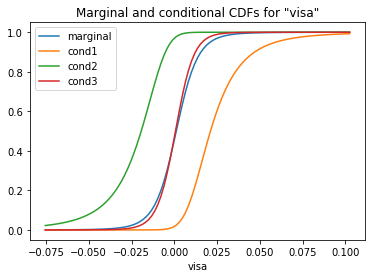

In [13]:
all_cdfs(to_keep[3])